# Packages

In [43]:
# Visualisation
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from pyvis.network import Network

# Data analysis / Data processing
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = "{:,.2f}".format
from datetime import time, timedelta, datetime
import numpy as np
import networkx as nx
from collections import defaultdict
import ast

# Maths & Stats
import math 
import scipy.stats as st
from scipy import stats
from scipy.stats import norm
import statsmodels.stats.weightstats as ws
from statsmodels.stats.proportion import test_proportions_2indep
import AB_library

# System library
import os
import ipywidgets
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
tqdm.pandas()
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%config InlineBackend.figure_format='retina'
# from itables import init_notebook_mode
# init_notebook_mode(all_interactive=True)
import openpyxl

# Data connection
from google.cloud import bigquery
bigquery_client = bigquery.Client(project='analytics-dev-333113')


# Useful functions
def cycle_sql(start, end, query, weeks=False):
    """
    You have to use {date} in your script to add cycle date into this backets
    """
    date_start = datetime.strptime(start, '%Y-%m-%d')
    date_end = datetime.strptime(end, '%Y-%m-%d')

    if weeks == False:
        daterange = [(date_start + timedelta(days=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days)+1)]
    else:
        daterange = [(date_start + timedelta(weeks=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days//7)+1)] # weeks dividing days by 7

    total_df = pd.DataFrame()

    counter = 0

    for date in daterange:
        counter+=1
        print(f"{counter}) Uploading - {date}:", datetime.today().strftime('%Y-%m-%d %H:%M:%S'))
        script = query.format(date = date)
        df_cycle = bigquery_client.query(script).to_dataframe()
        if df_cycle.empty == True:
            print('Dataframe is empty')
        total_df = pd.concat([df_cycle, total_df])
    return total_df

def read_bq(query, project='analytics-dev-333113'):
    client = bigquery.Client(project=project)
    query_job = client.query(query)
    result_df = query_job.to_dataframe()
    return result_df

def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(
        html_str.replace('table','table style="display:inline"'), 
        raw=True
    )

def writing_excel(name:str, dataset1=None, dataset2=None, dataset3=None, dataset4=None):
    with pd.ExcelWriter(f"{name}.xlsx") as writer:

    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet

        if dataset1 is not None:
            if dataset2 is not None:
                if dataset3 is not None:
                    if dataset4 is not None:
                        dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                        #   index=False
                                            )
                        dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                        #   index=False
                                            )
                        dataset3.to_excel(writer, sheet_name=f"3-{name}", 
                                        #   index=False
                                            )
                        dataset4.to_excel(writer, sheet_name=f"4-{name}", 
                                        #   index=False
                                            )
                    else:
                        dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                        #   index=False
                                            )
                        dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                        #   index=False
                                            )
                        dataset3.to_excel(writer, sheet_name=f"3-{name}", 
                                        #   index=False
                                            )
                else:
                    dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                    #   index=False
                                        )
                    dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                    #   index=False
                                        )
            else:
                dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                #   index=False
                                    )

        print('DataFrame is written to Excel File successfully.') 

# Research

In [3]:
df = read_bq("""
SELECT DISTINCT user_id,
                os_name,
                event_dt_part,
                city_id,
                country_id,
                city_name,
                country_name,
                fulfilled_flow,
                client_time,
                LOWER(status) AS status
FROM (SELECT user_id,
             name,
             os_name,
             event_dt_part,
             TIMESTAMP_MILLIS(client_time)                                           AS client_time,
             t1.city_id,
             t2.city_name,
             t2.country_id,
             t2.country_name,
             IF(LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                    OVER (PARTITION BY user_id, event_dt_part ORDER BY client_time) IS NULL,
                JSON_EXTRACT_SCALAR(payload, '$.verification_flow'),
                LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                    OVER (PARTITION BY user_id, event_dt_part ORDER BY client_time)) AS fulfilled_flow,
             JSON_EXTRACT_SCALAR(payload, '$.status')                                AS status
      FROM indriver-e6e40.ods_event_tracker.event t1
               JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                    ON
                        t1.city_id = t2.city_id
      WHERE 1 = 1
        AND name IN (
                     'client.verification_start.show',
                     'client.verification_flow_result_status.show'
          )
        AND event_dt_part >= '2025-01-01'
        AND t1.city_id IN
            (4516, 4257, 4228, 4549, 4264, 5536, 4142, 5528, 4200, 5535, 4231, 4153, 4373, 5600, 4269, 4226, 4397, 4755,
             5589, 4517, 4242, 4524, 4199, 4229, 5368, 4374, 4299, 4271, 4385, 798, 4154, 4376, 4196, 4266, 5573, 4261,
             4300, 4559, 5568, 4530, 4545, 4540, 4267, 4263))
WHERE name = 'client.verification_flow_result_status.show'
""")

df.head()
df['event_dt_part'] = pd.to_datetime(df['event_dt_part'])

,user_id,os_name,event_dt_part,city_id,country_id,city_name,country_name,fulfilled_flow,client_time,status
0,49247091,ios,2025-01-01,5573,25,Copiapó,Chile,liveness,2025-01-01 18:10:56.358000+00:00,approve
1,91471576,android,2025-02-09,4517,11,Natal,Brazil,liveness,2025-02-09 23:45:26.817000+00:00,approve
2,270723966,android,2025-01-24,4397,43,Portoviejo,Ecuador,liveness,2025-01-24 17:32:24.115000+00:00,approve
3,280615711,android,2025-02-11,4517,11,Natal,Brazil,liveness,2025-02-11 14:42:47.957000+00:00,approve
4,280708898,android,2025-02-12,5536,75,Tegucigalpa y Comayagüela,Honduras,liveness,2025-02-12 06:25:33.263000+00:00,approve


In [52]:
df[(df['fulfilled_flow']=='liveness')].groupby(['event_dt_part', 'city_name', 'fulfilled_flow'], as_index=False)['client_time'].count()

,event_dt_part,city_name,fulfilled_flow,client_time
0,2025-01-01,Antofagasta,liveness,830
1,2025-01-01,Arica,liveness,405
2,2025-01-01,Belo Horizonte,liveness,1
3,2025-01-01,Brasília,liveness,2996
4,2025-01-01,Calama,liveness,880
...,...,...,...,...
2989,2025-03-20,Tegucigalpa y Comayagüela,liveness,107
2990,2025-03-20,Temuco,liveness,79
2991,2025-03-20,Tijuana,liveness,371
2992,2025-03-20,Trujillo,liveness,530


In [68]:
df[(df['fulfilled_flow']=='liveness')].groupby(['event_dt_part', 'fulfilled_flow'], as_index=False)['client_time'].count()['client_time'].mean()

34033.83544303798

Text(0, 0.5, 'Number of attempts')

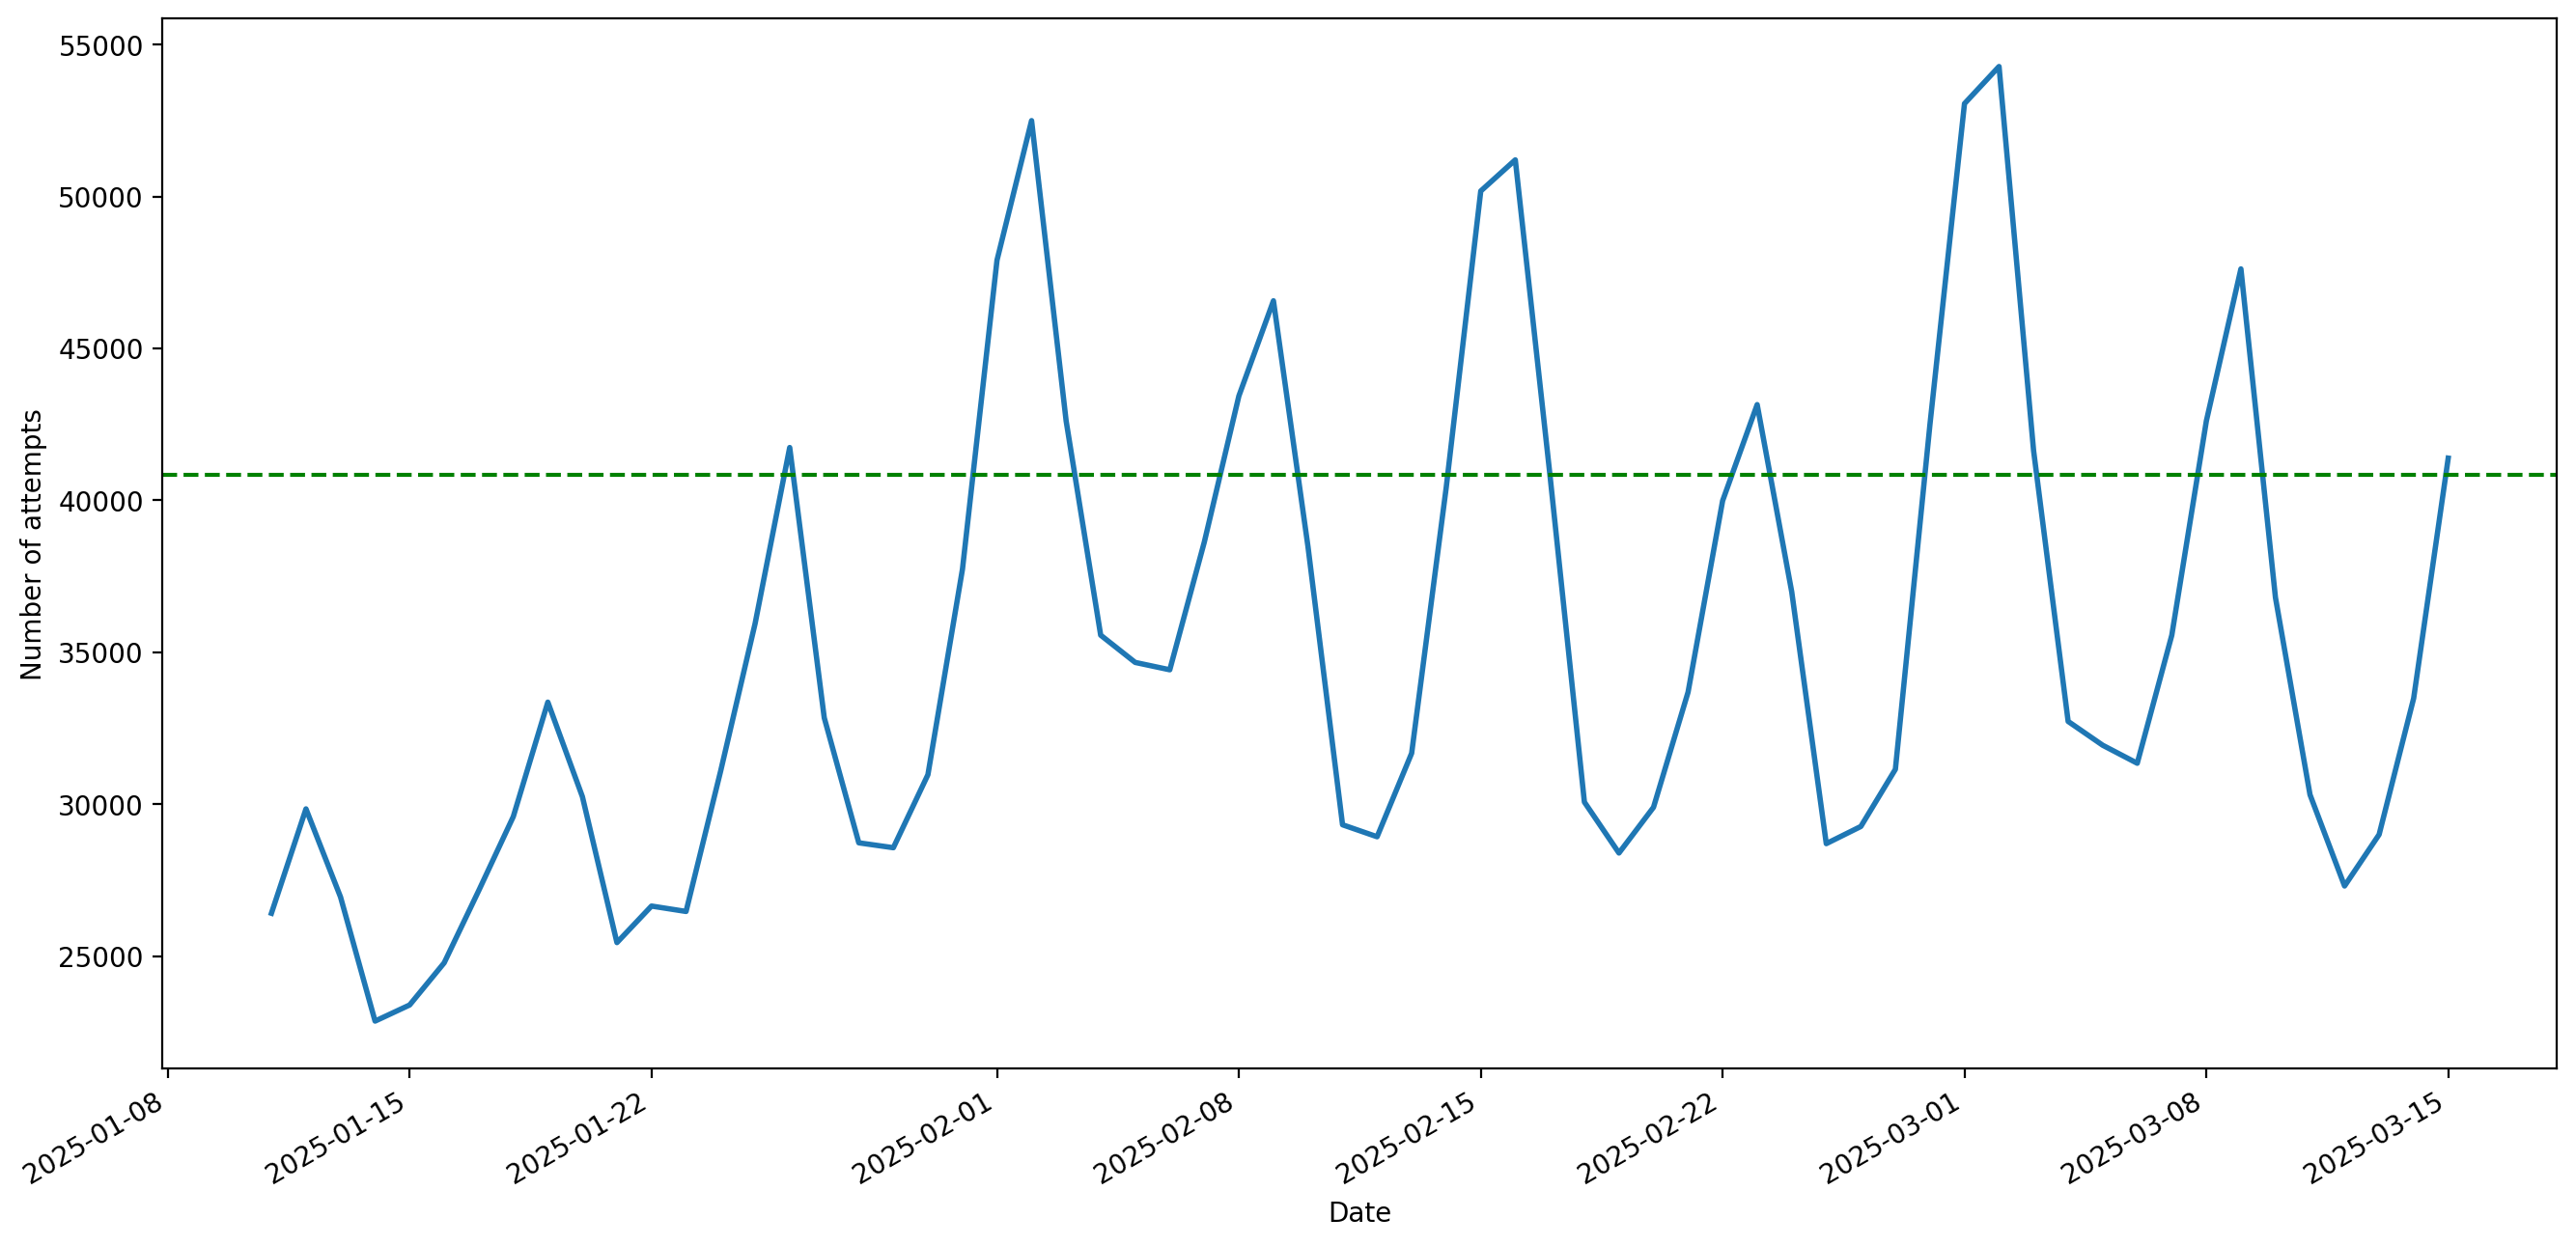

In [76]:
fig, ax = plt.subplots(figsize=(16, 8))
fig.autofmt_xdate()
ax.plot(
    df[(df['fulfilled_flow']=='liveness') & (df['event_dt_part']>'2025-01-10') & (df['event_dt_part']<'2025-03-16')].groupby(['event_dt_part', 'fulfilled_flow'], as_index=False)['client_time'].count()['event_dt_part'], 
    df[(df['fulfilled_flow']=='liveness')& (df['event_dt_part']>'2025-01-10')& (df['event_dt_part']<'2025-03-16')].groupby(['event_dt_part', 'fulfilled_flow'], as_index=False)['client_time'].count()['client_time'],
    lw=2
    )

mean = df[(df['fulfilled_flow']=='liveness')].groupby(['event_dt_part', 'fulfilled_flow'], as_index=False)['client_time'].count()['client_time'].mean()
plt.axhline(y=mean*1.2, color='green', linestyle='--', label='Reference Line (Median)')


ax.set_xlabel("Date", color='black', fontsize=10)
ax.set_ylabel("Number of attempts", color='black', fontsize=10)

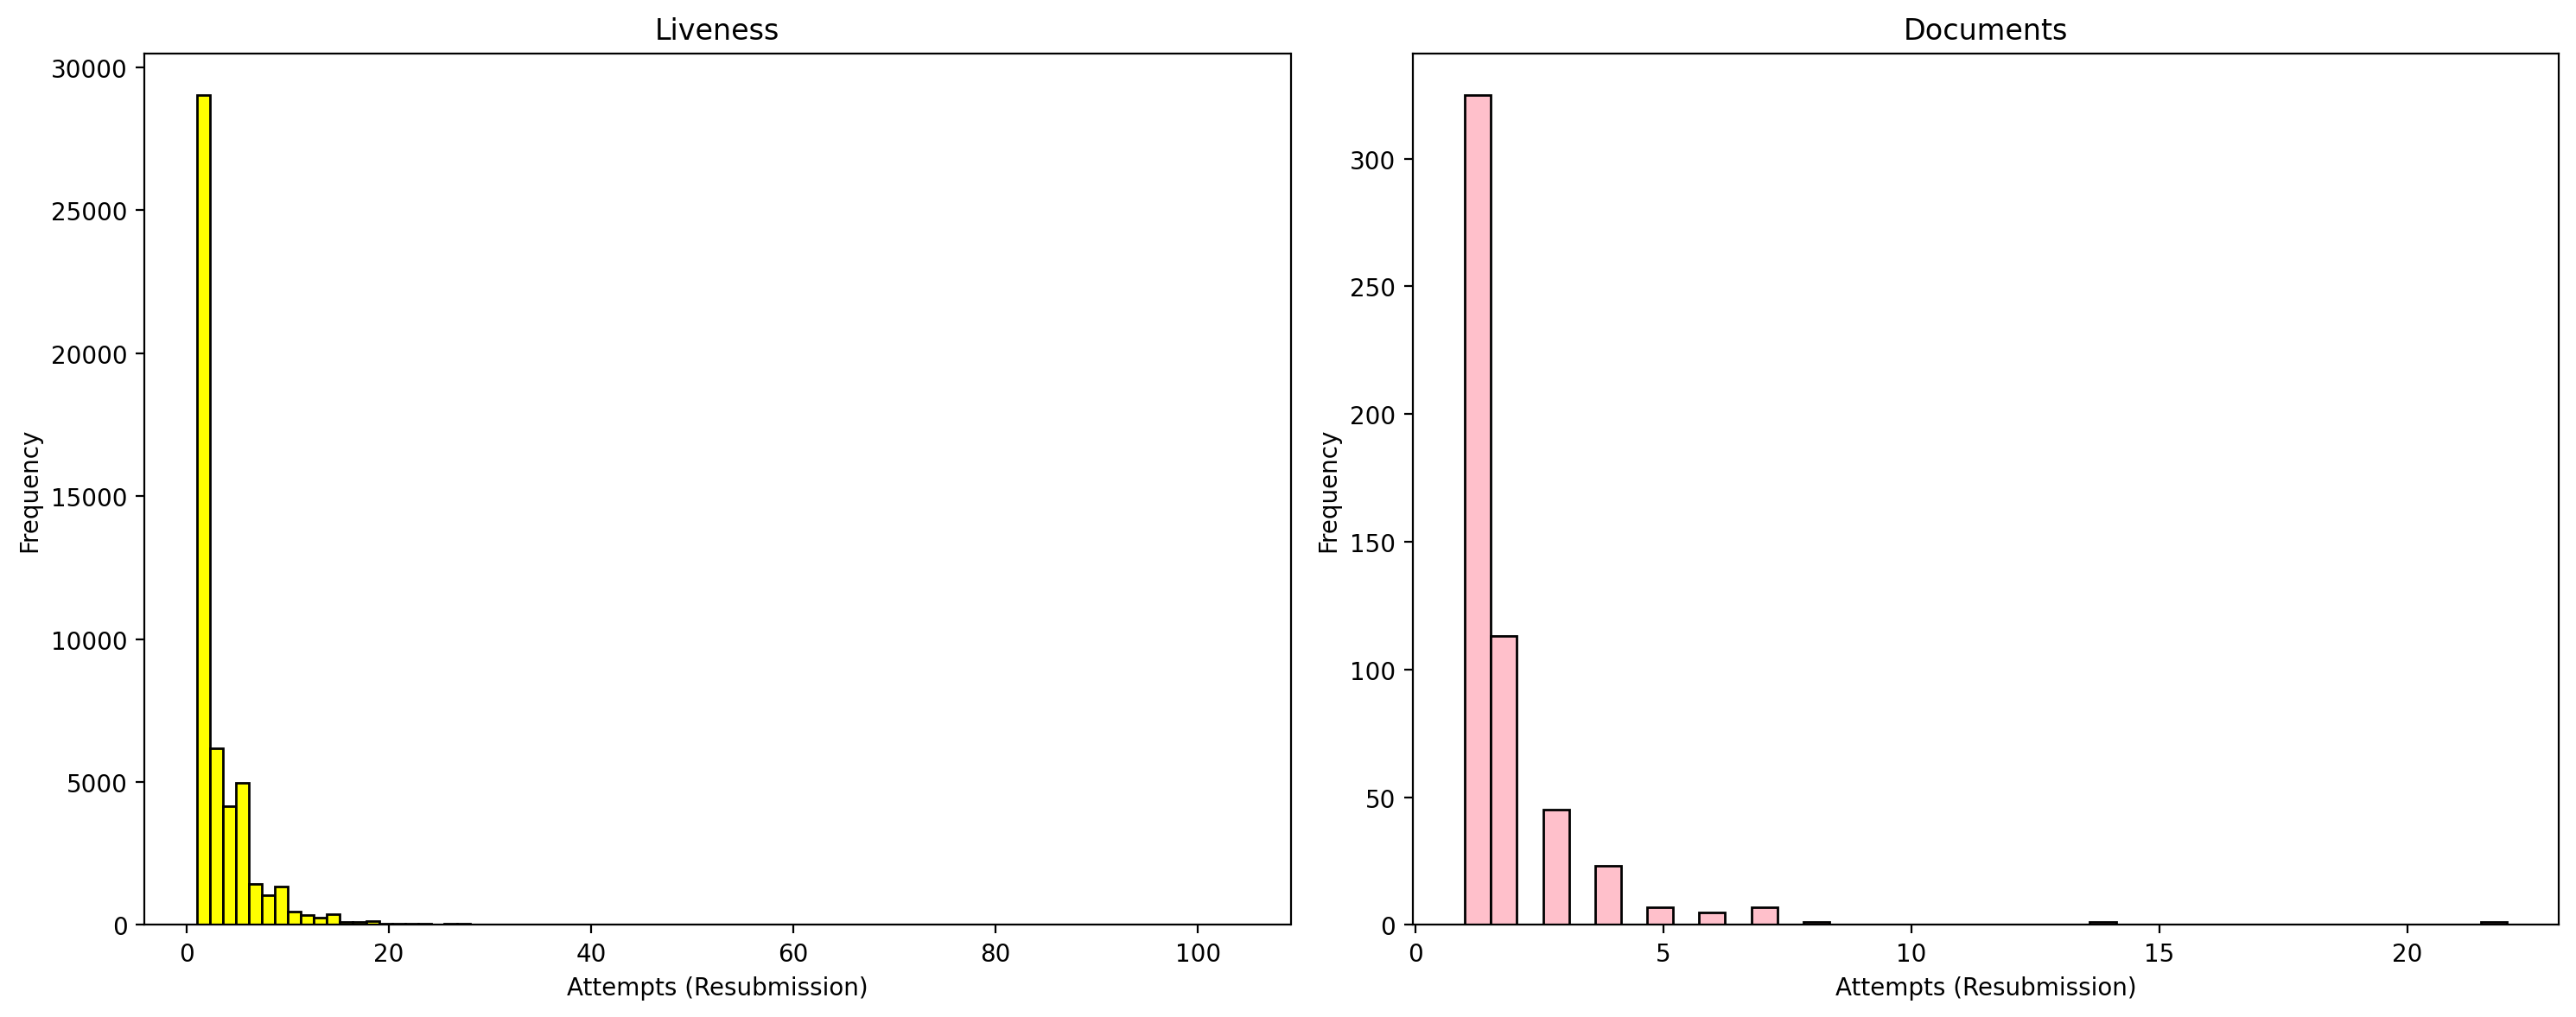

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
 
axes[0].hist(df[(df['fulfilled_flow']=='liveness') & (df['status']!='approve')].groupby(['user_id', 'city_name', 'fulfilled_flow', 'status'], as_index=False)['client_time'].count()['client_time'], 
             bins=80, 
             color='Yellow', 
             edgecolor='black'
    )
axes[0].set_title('Liveness')
 
axes[1].hist(df[(df['fulfilled_flow']=='documents') & (df['status']!='approve')].groupby(['user_id', 'city_name', 'fulfilled_flow', 'status'], as_index=False)['client_time'].count()['client_time'], 
             bins=40, 
             color='Pink', 
             edgecolor='black'    
    )
axes[1].set_title('Documents')
 
for ax in axes:
    ax.set_xlabel('Attempts (Resubmission)')
    ax.set_ylabel('Frequency')
 
# Adjusting layout for better spacing
plt.tight_layout()
 
# Display the figure
plt.show()

In [90]:
np.percentile(
    df[(df['fulfilled_flow']=='liveness') & (df['status']!='approve')].groupby(['user_id', 'city_name', 'fulfilled_flow', 'status'], as_index=False)['client_time'].count()['client_time'],
    99
)

18.0

In [32]:
df_agg = df.groupby(['user_id', 'city_name', 'fulfilled_flow'], as_index=False)['client_time'].count()

In [47]:
df_agg.groupby(['city_name', 'fulfilled_flow'], as_index=False)[['client_time']].sum().sort_values(['city_name', 'fulfilled_flow', 'client_time'], ascending=False)

,city_name,fulfilled_flow,client_time
52,Villavicencio,liveness,16552
51,Trujillo,liveness,111002
50,Tijuana,liveness,59258
49,Temuco,liveness,16312
48,Tegucigalpa y Comayagüela,liveness,14667
47,São Paulo,liveness,147126
46,São Paulo,documents,2
45,Santiago de los Caballeros,liveness,12882
44,Santiago,liveness,150844
43,Santiago,documents,1


In [40]:
df_agg.pivot_table(columns='client_time', index=['city_name'], values='user_id', aggfunc='count').fillna(0)

client_time,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,47,48,49,51,52,53,54,55,57,64,67,71,82,105
city_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Antofagasta,32281,2101,294,131,80,50,44,29,24,20,17,10,10,5,10,9,2,3,2,1,1,2,2,0,3,1,0,1,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arica,18446,1121,140,65,48,33,21,10,22,7,10,5,3,3,1,5,2,2,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
Belo Horizonte,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Brasília,62682,9061,976,318,170,103,71,44,30,27,17,11,8,5,4,2,4,2,0,2,0,1,0,2,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Calama,22901,1917,384,161,95,49,35,35,20,17,17,12,13,5,7,4,5,1,1,1,0,2,3,0,0,0,2,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Campinas,22804,3028,265,87,33,24,14,8,8,7,1,6,6,4,1,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Cape Town,106282,5156,969,435,308,204,162,123,77,63,46,45,31,29,23,18,12,9,9,8,5,4,3,3,2,2,3,2,0,0,2,1,1,0,3,0,0,0,1,0,0,2,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0
Concepción,23764,2490,273,123,61,37,28,20,14,7,6,4,2,3,1,1,1,1,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Copiapó,9041,567,78,28,28,24,10,9,5,4,1,2,2,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
